# Predictive modeling of gene expression based on enhancer features

References:

Kulkarni, Meghana M., and David N. Arnosti. 2003. “Information Display by Transcriptional Enhancers.” Development  130 (26): 6569–75.

Fulco, Charles P., Joseph Nasser, Thouis R. Jones, Glen Munson, Drew T. Bergman, Vidya Subramanian, Sharon R. Grossman, et al. 2019. “Activity-by-Contact Model of Enhancer-Promoter Regulation from Thousands of CRISPR Perturbations.” Nature Genetics 51 (12): 1664–69.

Boer, Carl G. de, Eeshit Dhaval Vaishnav, Ronen Sadeh, Esteban Luis Abeyta, Nir Friedman, and Aviv Regev. 2019. “Deciphering Eukaryotic Gene-Regulatory Logic with 100 Million Random Promoters.” Nature Biotechnology, December. https://doi.org/10.1038/s41587-019-0315-8.

Pliner, Hannah A., Jonathan S. Packer, José L. McFaline-Figueroa, Darren A. Cusanovich, Riza M. Daza, Delasa Aghamirzaie, Sanjay Srivatsan, et al. 2018. “Cicero Predicts Cis-Regulatory DNA Interactions from Single-Cell Chromatin Accessibility Data.” Molecular Cell, July. https://doi.org/10.1016/j.molcel.2018.06.044.

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
# import statsmodels.api as sm

import matplotlib.pyplot as plt
import time
import pickle

import sklearn.linear_model as sklm

In [2]:
datadir='/cndd2/ethan/projects/scf_paper/modeling/working_data/reptile/data_for_model_01152020/'

In [3]:
# Load data
with open(datadir+'enhancer_by_clstmcg_by_gene.pkl', 'rb') as fid:
    mcg = pickle.load(fid)
with open(datadir+'enhancer_by_clstatac_by_gene.pkl', 'rb') as fid:
    atac = pickle.load(fid)
    
rna = pd.read_csv(datadir+'rna_for_y_values.tsv',sep='\t')
rna=rna.drop('10-1',axis=1)
rna_data = rna.iloc[:,2:].to_numpy()

In [4]:
rna_data.shape, mcg.shape, atac.shape

((19736, 28), (10, 28, 19736), (10, 28, 19736))

In [7]:
# Variable genes
hvg = np.var(rna_data,axis=1);
hvg = hvg> np.percentile(hvg,70)
np.sum(hvg)

5921

# Correlate gene body mC with RNA

In [8]:
datadir='/cndd/emukamel/enhancer_modeling/cluster_level'
rna = pd.read_csv(datadir+'/gene_features_smarter_cells_round3.tsv',sep='\t',index_col=0)
mch = pd.read_csv(datadir+'/gene_features_mch_round3.tsv',sep='\t',index_col=0)
atac = pd.read_csv(datadir+'/gene_features_snatac_gene_round3.tsv',sep='\t',index_col=0)

celltypes = rna.columns

rna.columns = [c+'_rna' for c in rna.columns]
mch.columns = [c+'_mch' for c in mch.columns]
atac.columns = [c+'_atac' for c in atac.columns]


# Variable genes
rna['rna_var'] = np.nanvar(rna,axis=1)

In [9]:
celltype_use = '1-1-1'
# celltype_use = celltypes
# data = rna.loc[:,[celltype_use+'_rna']]
# data = data.join(mch.loc[:,[celltype_use+'_mch']],lsuffix='_rna',rsuffix='_mch')
# data = data.join(atac.loc[:,[celltype_use+'_atac']],rsuffix='_atac')

data = pd.concat([rna.loc[:,[celltype_use+'_rna']],
                 mch.loc[:,[celltype_use+'_mch']],
                 atac.loc[:,[celltype_use+'_atac']]],axis=1)

data = data.join(rna.loc[:,'rna_var'])
data = data.dropna(axis=1,how='all') # Remove columns that have no good data
data = data.dropna(axis=0,how='any') # Remove genes missing some data
hvg = data['rna_var']>np.percentile(data['rna_var'],80)
data = data[hvg]

mch['var_mch'] = np.var(mch,axis=1)
mch['mean_mch'] = np.mean(mch,axis=1)
mch['min_mch'] = np.min(mch,axis=1)
mch['max_mch'] = np.max(mch,axis=1)
data = data.join(mch[['var_mch','mean_mch','min_mch','max_mch']])

atac['var_atac'] = np.var(atac,axis=1)
atac['mean_atac'] = np.mean(atac,axis=1)
atac['min_atac'] = np.min(atac,axis=1)
atac['max_atac'] = np.max(atac,axis=1)
data = data.join(atac[['var_atac','mean_atac','min_atac','max_atac']])
data

,1-1-1_rna,1-1-1_mch,1-1-1_atac,rna_var,var_mch,mean_mch,min_mch,max_mch,var_atac,mean_atac,min_atac,max_atac
ENSMUSG00000043644,1.219074,0.267349,1.706314,0.074690,0.007230,0.232686,0.007230,0.425857,0.503961,1.457379,0.0,2.600049
ENSMUSG00000024442,0.931338,0.411635,1.387543,0.047650,0.007287,0.401771,0.007287,0.756449,0.198878,1.274940,0.0,1.911612
ENSMUSG00000058706,1.510064,0.312000,1.816305,0.067540,0.004471,0.249136,0.004471,0.491645,0.371897,1.457671,0.0,2.277715
ENSMUSG00000089889,1.321793,0.428225,1.045320,0.063852,0.050808,0.418666,0.000000,1.619489,0.323861,0.716533,0.0,1.610050
ENSMUSG00000097134,0.096739,1.469112,0.857453,0.068170,0.128611,1.096731,0.128611,1.672464,0.270036,0.857898,0.0,1.773838
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000054715,1.218406,0.292235,1.082539,0.074651,0.003884,0.267203,0.003884,0.541283,0.212088,0.767073,0.0,1.482757
ENSMUSG00000022228,1.458575,0.316533,1.286444,0.057925,0.006148,0.293904,0.006148,0.608232,0.249157,1.156944,0.0,2.074775
ENSMUSG00000050619,0.567897,0.553086,0.964002,0.050657,0.011391,0.520655,0.011391,0.768951,0.224971,0.712997,0.0,1.854997
ENSMUSG00000073062,1.269666,0.342939,0.718182,0.057731,0.034441,0.319365,0.000000,1.387792,0.133091,0.435805,0.0,1.201187


In [10]:
# Simple correlation of RNA with mCH or ATAC
ncelltypes = len(celltypes)
cc_mch = np.zeros(ncelltypes)+np.nan
cc_atac = np.zeros(ncelltypes)+np.nan
cc_mch_atac = np.zeros(ncelltypes)+np.nan
data = pd.concat([rna,mch,atac],axis=1)
data = data.dropna(axis=1,how='all')
data = data.dropna(axis=0,how='any')
hvg = data['rna_var']>np.percentile(data['rna_var'],80)
data = data[hvg]

ngenes = data.shape[0]
for i,celltype in enumerate(celltypes):
    try:
        cc_mch[i] = np.corrcoef( data.loc[:,celltype+'_rna'], -data.loc[:,celltype+'_mch'] )[0,1]
        cc_atac[i] = np.corrcoef( data.loc[:,celltype+'_rna'], data.loc[:,celltype+'_atac'] )[0,1]
        
        X = data.loc[:,[celltype+'_mch',celltype+'_atac','var_mch','mean_mch','min_mch','max_mch',
                       'var_atac','mean_atac','min_atac','max_atac']]

#         X = data.loc[:,[celltype+'_mch',celltype+'_atac']]
        y = data.loc[:,[celltype+'_rna']]

        regr = sklm.LinearRegression().fit(X,y)
        cc = np.corrcoef(y.to_numpy().T, regr.predict(X).T)[0,1]
        cc_mch_atac[i]=cc
        
    except: {}

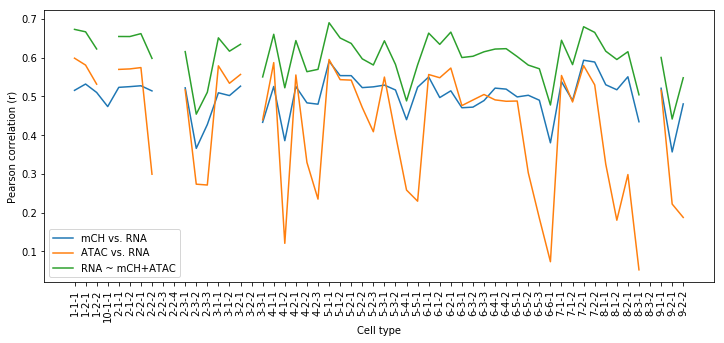

In [11]:
plt.figure(figsize=(12,5))
plt.plot(celltypes, cc_mch, label='mCH vs. RNA');
plt.plot(celltypes, cc_atac, label='ATAC vs. RNA');
plt.plot(celltypes, cc_mch_atac, label='RNA ~ mCH+ATAC');
plt.legend()
plt.ylabel('Pearson correlation (r)')
plt.xlabel('Cell type')
plt.xticks(rotation=90);

# Extra stuff

In [408]:
# Regularized (elastic net) regression
celltype_use = celltypes
X = data.loc[:,[c+'_mch' for c in celltype_use]+['var_mch','mean_mch','min_mch','max_mch']]
y = data.loc[:,[c+'_rna' for c in celltype_use]]
X.shape, y.shape

/cndd/emukamel/conda_envs/cembadata_eran/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


((21158, 60), (21158, 56))

In [308]:
data.sample(frac=1).reset_index(drop=True)

,1-1-1_rna,1-2-1_rna,1-2-2_rna,10-1-1_rna,2-1-1_rna,2-1-2_rna,2-2-1_rna,2-2-2_rna,2-2-3_rna,2-3-1_rna,...,8-2-1_mch,8-3-1_mch,9-1-1_mch,9-2-1_mch,9-2-2_mch,rna_var,var_mch,mean_mch,min_mch,max_mch
0,1.985411,1.349371,1.105394,1.461278,0.000000,0.017441,0.012344,0.006278,0.009671,0.010894,...,1.085427,1.095707,1.306658,1.307359,1.291821,0.362458,0.061141,1.112470,0.061141,1.772345
1,1.346745,1.273815,1.341685,1.149504,1.308643,1.214744,1.188787,0.964720,1.052017,1.132544,...,0.291406,0.088218,0.231233,0.166515,0.170479,0.067996,0.004547,0.249942,0.004547,0.400562
2,0.486669,0.411562,0.280227,0.010543,0.492355,0.531107,0.328325,0.168896,0.206922,0.573989,...,1.228390,1.295105,0.824763,1.074265,0.782727,0.061496,0.032871,0.945238,0.032871,1.295105
3,1.724063,1.748584,1.693371,0.000000,0.921233,1.071919,0.970518,1.229147,0.893120,1.309313,...,1.941588,0.709923,1.927650,0.604009,1.206477,0.249802,0.405697,0.949157,0.143554,2.246440
4,1.227607,1.679803,1.341888,1.327111,1.752422,1.719360,1.979588,2.089317,1.401940,1.906146,...,0.740953,1.697441,1.140709,1.234103,0.887650,0.544194,0.182189,1.125176,0.182189,2.250613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,0.040756,0.046320,0.066641,0.000000,0.000000,0.000000,0.000744,0.000000,0.000000,0.000000,...,1.873673,1.772179,1.842309,1.776076,1.688656,0.080775,0.087427,1.742058,0.087427,2.200980
4228,0.615667,0.669181,0.599284,0.156807,0.639941,0.530311,0.629850,0.658385,0.620387,0.541481,...,1.454621,1.423383,1.470564,1.524520,1.454075,0.049945,0.049631,1.392964,0.049631,1.752142
4229,1.119041,1.336243,1.188076,0.264586,0.742361,0.681868,0.789537,0.933226,1.456908,0.000000,...,0.166894,0.353491,0.132698,0.140268,0.183564,0.460033,0.007677,0.164777,0.000000,0.356741
4230,0.386563,0.405314,0.278980,0.680190,0.773883,0.711983,0.643513,0.733973,0.339832,0.850879,...,0.631664,0.938523,0.871930,0.885628,1.017772,0.065644,0.125776,0.916987,0.125776,1.825194


In [311]:
# Regularized (elastic net) regression
myregr = []
mse_min = {}
X=data.filter(axis=1,regex='_mch')
# X = X.sample(frac=1).reset_index(drop=True)
for celltype in celltypes:
    celltype_use = [celltype]
    try:
#         X = data.loc[hvg,[c+'_mch' for c in celltype_use]+['var_mch','mean_mch','min_mch','max_mch']]
#         X = data.loc[hvg,['var_mch']]
        y = data.loc[hvg,[c+'_rna' for c in celltype_use]]

        regr = sklm.ElasticNetCV(random_state=0, 
                                        normalize=True, 
                                        n_alphas=20, 
                                        cv=5)
        regr.fit(X, np.ravel(y))
        myregr.append(regr)
        mse_min[celltype] = regr.mse_path_.mean(axis=1).min()
    except:
        print('Failed %s'% celltype)
print('Mean MSE=%3.3f ± %3.3f' % (np.mean(list(mse_min.values())), np.std(list(mse_min.values()))))

Failed 2-2-4
Failed 3-2-2
Mean MSE=0.264 ± 0.041


<BarContainer object of 54 artists>

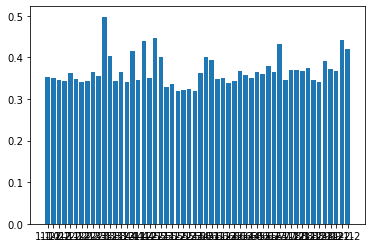

In [310]:
plt.bar(mse_min.keys(), mse_min.values())

IndexError: list index out of range

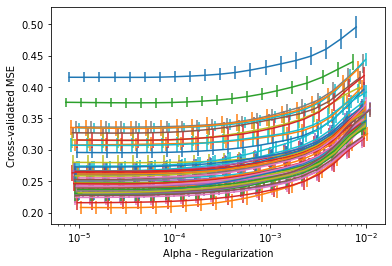

In [281]:
# Plot cross-validation curve

for i,celltype in enumerate(celltypes):
    regr = myregr[i]
    plt.errorbar(regr.alphas_, np.mean(regr.mse_path_,axis=1), np.std(regr.mse_path_,axis=1)/np.sqrt(regr.cv))
    plt.xlabel('Alpha - Regularization')
    plt.ylabel('Cross-validated MSE')
    plt.xscale('log')